In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
from src.smalldiffusion.diffusion import ScheduleLogLinear, classifier_free_guidance_training_loop, conditioned_samples
from src.smalldiffusion.data import StarDataset
from src.smalldiffusion.model import (
    TimeInputMLPConditional, get_sigma_embeds
)


import torch
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

def plot_batch(batch, label=None, marker='.', color=None):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker=marker, label=label, color=color)
    # plt.xlim(-4,4)
    # plt.ylim(-4,4)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w



torch.Size([500]) torch.Size([500]) torch.Size([500])


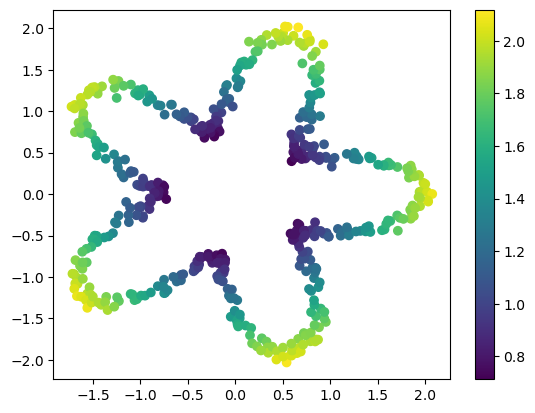

In [42]:
import torch.distributions as dist
# sample from the dataset given a radius
# Define a desired radius distribution
radius_mean = 1.5
radius_std = 0.3
radii_dist = dist.Normal(radius_mean, radius_std)


dataset = StarDataset(radius=2, n_points=500, seed=0)
loader = DataLoader(dataset, batch_size=100, shuffle=True)
print(dataset.data[:, 0].shape, dataset.data[:, 1].shape, dataset.radii[:, 0].shape)
fig, ax = plt.subplots()
im = ax.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0])
fig.colorbar(im, ax=ax)
plt.show()

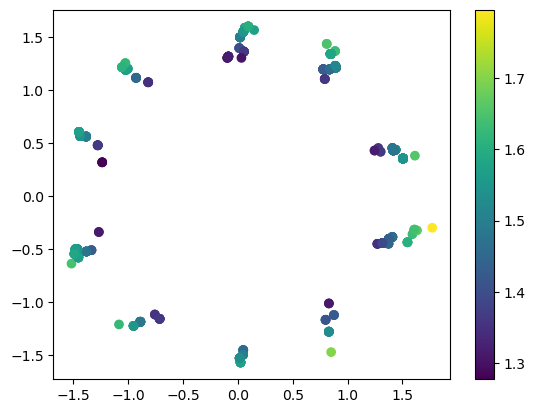

In [47]:

# plot the dataset
# fig, ax = plt.subplots()
# im = ax.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0])
# fig.colorbar(im, ax=ax)
# plt.show()

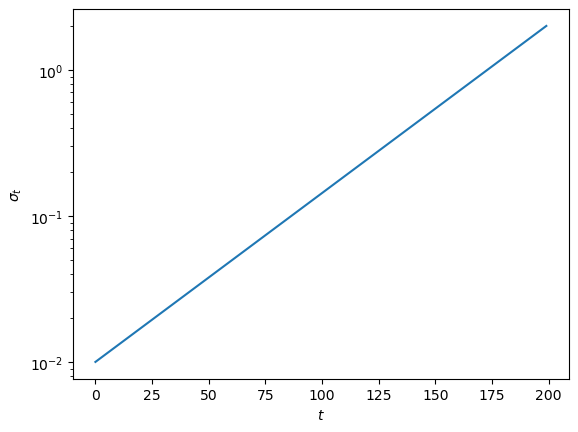

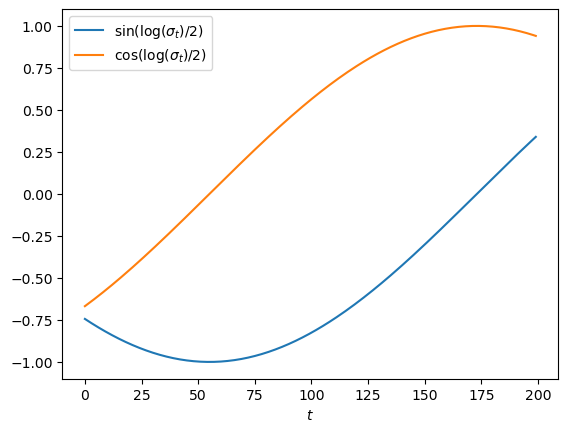

In [24]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=2)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')
plt.show()

sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [25]:
model = TimeInputMLPConditional(dim=2, cond_dim=1, cond_hid_dim=16, hidden_dims=(16,128,256,128,16))
trainer = classifier_free_guidance_training_loop(loader, model, schedule, epochs=1000, lr=1e-3, drop_prob=0.2)
losses = [ns.loss.item() for ns in trainer]
# save model
torch.save(model.state_dict(), './checkpoints/star_model.pth')

loss: 0.8904:   0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.5017: 100%|██████████| 1000/1000 [00:12<00:00, 79.71it/s]


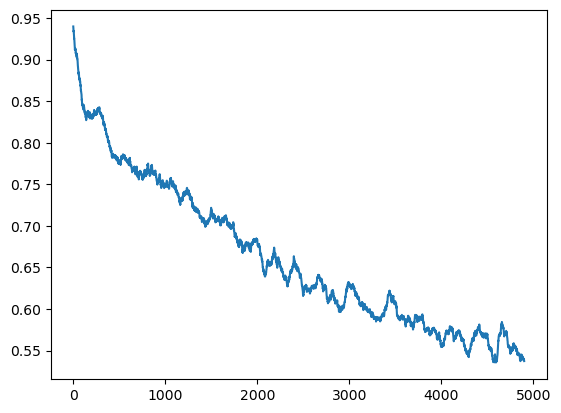

In [26]:
plt.plot(moving_average(losses, 100))
plt.show()

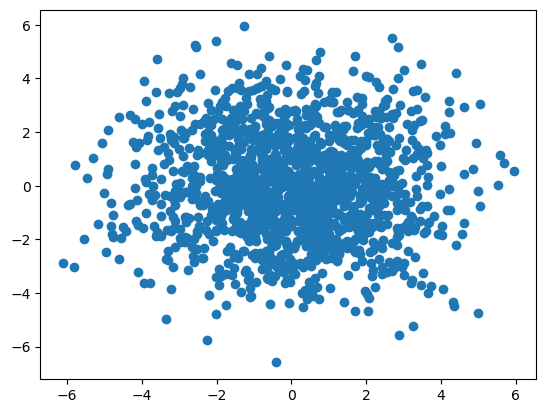

In [27]:
xT = model.rand_input(1500)* schedule.sample_sigmas(50)[0]
plt.scatter(xT[:,0], xT[:,1])

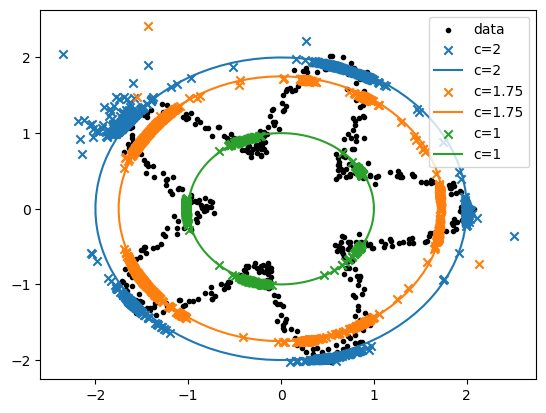

In [28]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
plot_batch(dataset.data, label='data', marker='.', color='black')
# plt.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0], label='data')

guide_w = 2.0
gam=1
mu=0
steps=50
t = np.linspace(0, 2*np.pi, 100)
num_samples = 1500
radii = [2,1.75, 1]

# conditions = None
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=none', marker='.')

for r in radii:
    conditions = torch.ones(num_samples,1)*r
    *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
    plot_batch(x0, label=f'c={r}', marker='x')
    plt.plot(r*np.cos(t), r*np.sin(t), label=f'c={r}')

# conditions = torch.ones(num_samples,1)*3
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=3', marker='x')

# conditions = torch.ones(num_samples,1)*2
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=2', marker='x')
# # plot a circle of the radius
# plt.plot(2*np.cos(t), 2*np.sin(t), label='c=2')

# conditions = torch.ones(num_samples,1)*1
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1', marker='x')
# plt.plot(1*np.cos(t), 1*np.sin(t), label='c=1')

# conditions = torch.ones(num_samples,1)*1.75
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1.75', marker='x')

# conditions = torch.ones(num_samples,1)*0.1
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=0.1', marker='x')

plt.legend()



In [ ]:
# plot xT - denoised(x0) for different levels of noise and x0

x = np

Now - consider a noisy reward model - radii not perfect. Also make OOD radii better, currently we can't even tell what the c=5 should be.
- can do this by filtering by radii, or following a distribution of radii.

What is p(x) under the generating model?

<Axes: ylabel='Count'>

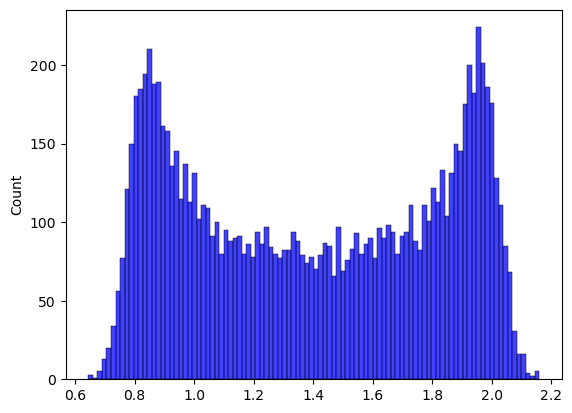

In [19]:
import seaborn as sns

sns.histplot(dataset.radii[:, 0], bins=100, color='blue', label='radius')

# we want the distribution to be normal with mean 1.4 and std 1
# we can do this by filtering radii
